In [1]:
import os
from pathlib import Path
import numpy as np
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from lib.city_blocks import load_street_graph, remove_deadends, city_blocks
from lib.config import tmp_folder_path
import matplotlib.pyplot as plt

%matplotlib inline

In [16]:
def fix_polygon(pol, fixed_pgs):
    if isinstance(pol, MultiPolygon):
        #print('Multipolygon instance')
        for p in pol.geoms:
            clean = p.buffer(0.0)
            if clean.geom_type == 'Polygon':
                if clean.is_valid:
                    p = clean
                    fixed_pgs.append(p)
            elif clean.geom_type == 'MultiPolygon':
                fix_polygon(clean, fixed_pgs)
    else:
        clean = pol.buffer(0.0)
        if clean.geom_type == 'Polygon':
            if clean.is_valid:
                pol = clean
                fixed_pgs.append(pol)
        elif clean.geom_type == 'MultiPolygon':
            fix_polygon(clean, fixed_pgs)

In [38]:
city_polygon = gpd.read_file('geojson/cut_grid.json').to_crs({'init': 'epsg:4237'}).geometry.unary_union

In [39]:
street_graph = ox.graph_from_polygon(city_polygon, simplify=False, network_type='drive')

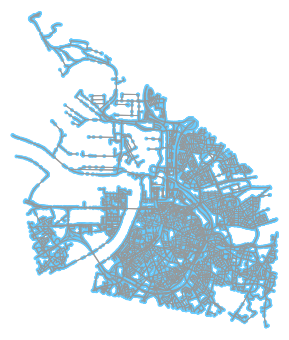

(<Figure size 581.899x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe569978ac8>)

In [40]:
ox.plot_graph(street_graph)

## Simplify graph by removing dead-end roads
Removing the dead-end roads does not affect the shape of the city blocks. 

In [41]:
street_graph = remove_deadends(street_graph)

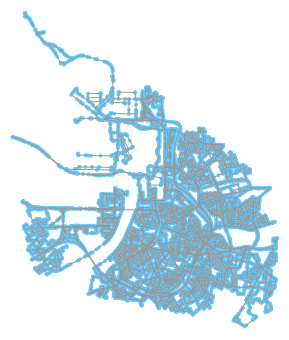

(<Figure size 582.642x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe5654ff3c8>)

In [42]:
ox.plot_graph(street_graph)

## Calculate city blocks

In [43]:
blocks = city_blocks(street_graph)

  0%|          | 242/58578 [00:04<23:45, 40.92it/s]/project/code/geoviz/lib/city_blocks.py:16: RuntimeWarning: invalid value encountered in arccos
  return np.degrees(np.arccos(np.dot(a, b)/(norm(a)*norm(b))))*np.sign(np.cross(b,a))
100%|██████████| 58578/58578 [32:34<00:00, 29.97it/s]


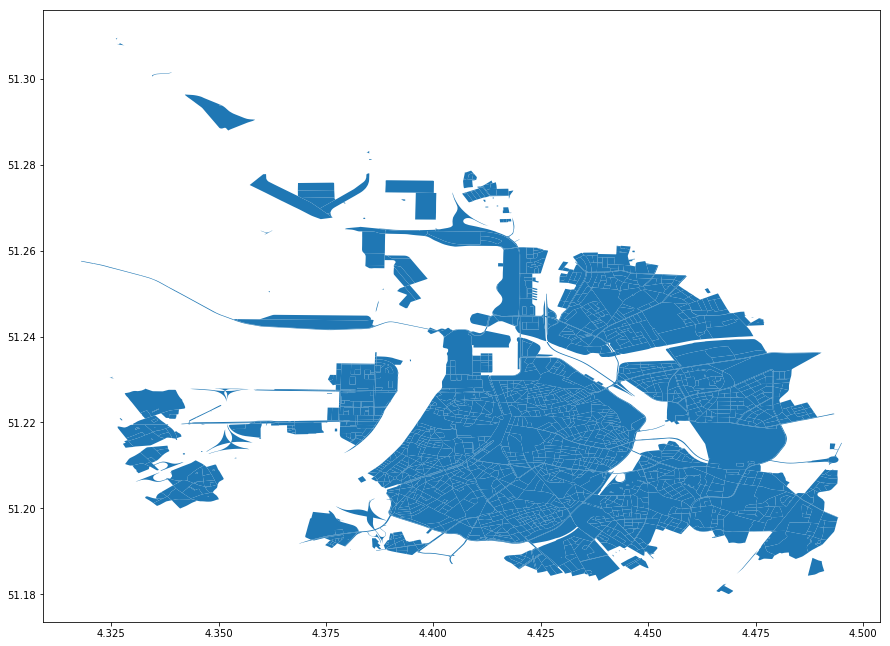

In [44]:
blocks.plot(figsize=(15,15))

In [45]:
print('number of areas: {}'.format(len(blocks)))

number of areas: 2694


In [46]:
original_blocks = blocks

## Dealing with invalid polygons

When calculating city blocks for larger areas, it will often happen that some of the polygons representing the city blocks are invalid. This means that the polygons are complex and have self-intersections. We can deal with this by applying some shapely magic.  

First, we find the invalid polygons and plot them.

In [47]:
blocks[blocks.is_valid == True].shape

(2657, 1)

In [48]:
blocks[blocks.is_valid == False].shape

(37, 1)

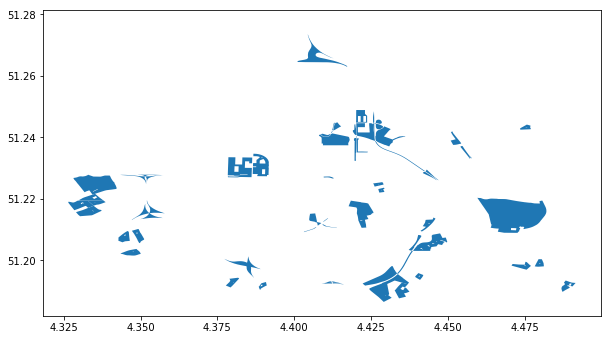

In [49]:
invalid = blocks[blocks.is_valid == False]
if not invalid.empty: 
    invalid.plot(figsize=(10,10))

Fix polygons and create second dataframe

In [50]:
fixed = [ ]
       
for _,pol in invalid.geometry.iteritems():
    #pol = pol.buffer(0.0)
    fix_polygon(pol, fixed)

fixed = gpd.GeoDataFrame({'geometry':fixed})
fixed = fixed[fixed.is_empty == False]

Remove the invalid polygons from the dataframe and append fixed polygons

In [51]:
#blocks = original_blocks

In [52]:
blocks = blocks[blocks.is_valid == True]
blocks = blocks.append(fixed)
blocks.reset_index(inplace=True, drop=True)

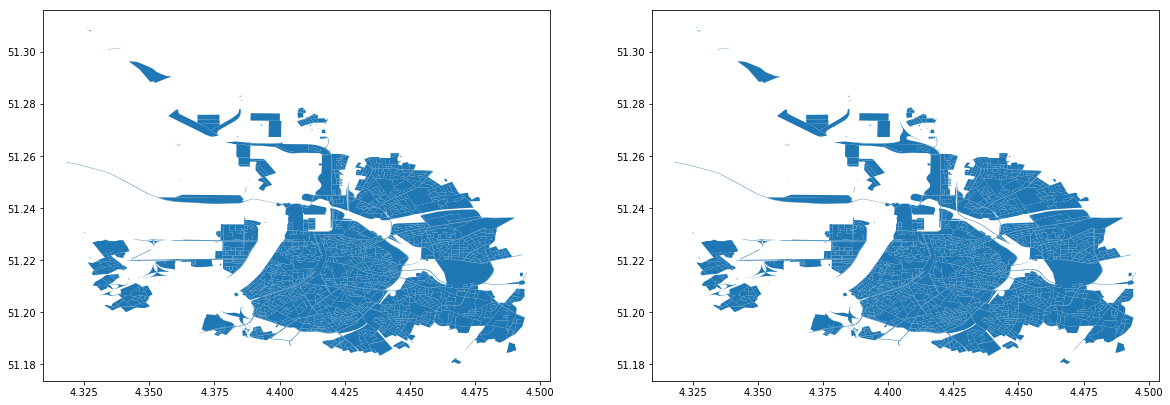

In [53]:
_, axes = plt.subplots(figsize=(20,20), nrows=1, ncols=2)
blocks.plot(ax = axes[0])
original_blocks.plot(ax = axes[1])

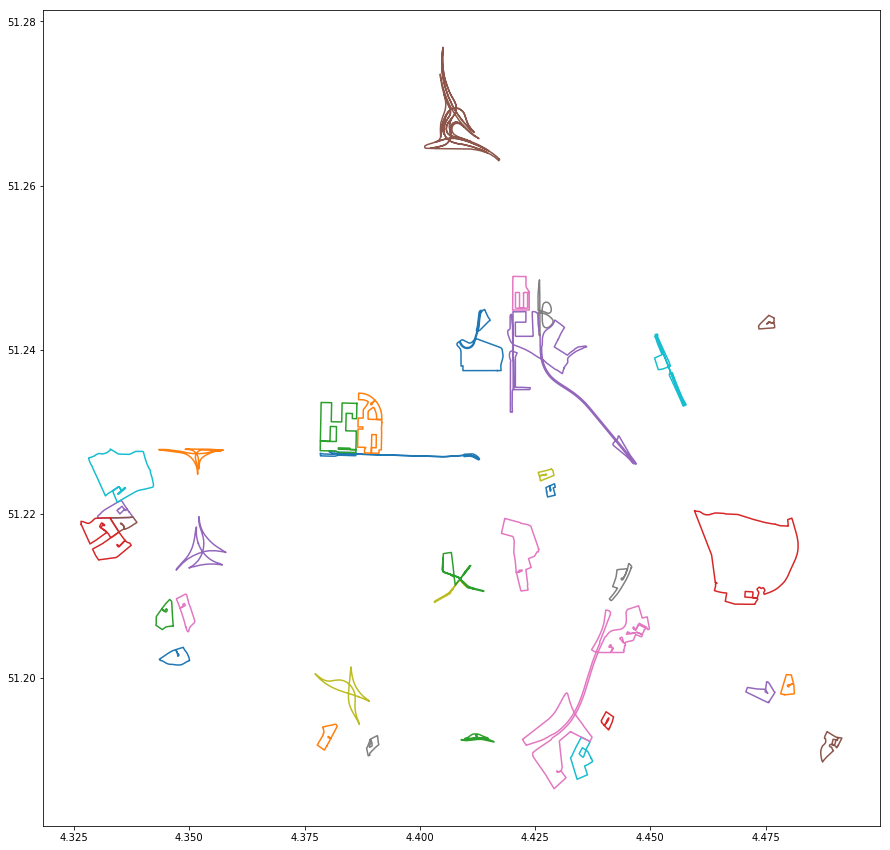

In [54]:
plt.figure(figsize=(15,15))
for g in invalid.geometry:
  plt.plot(*g.exterior.xy)

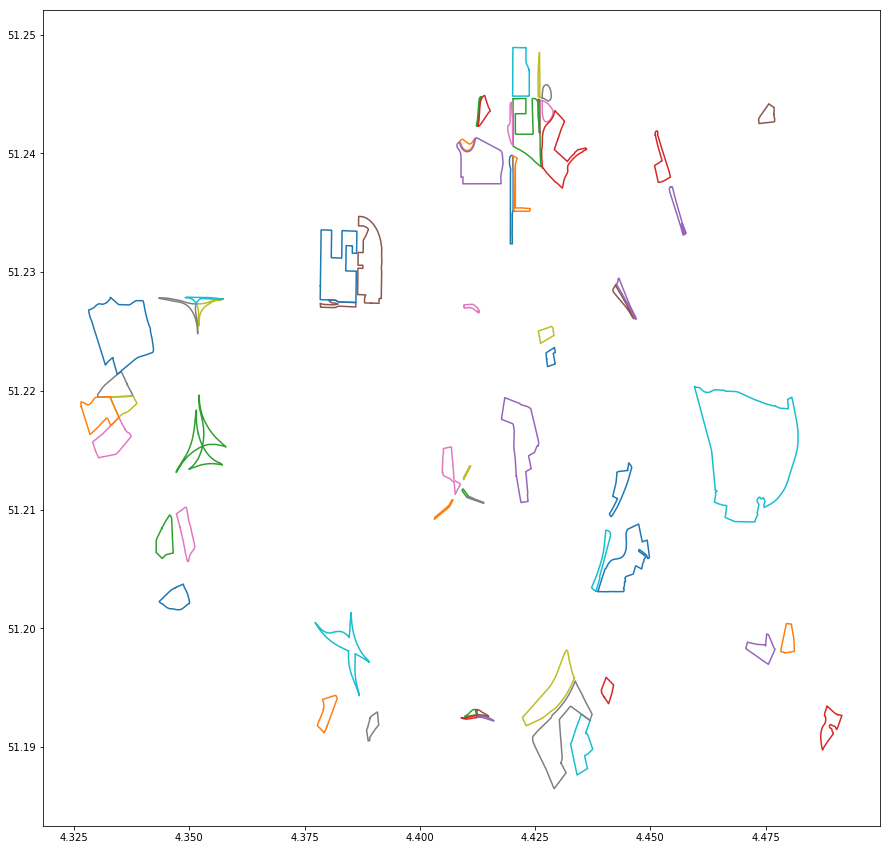

In [55]:
plt.figure(figsize=(15,15))
for g in fixed.geometry:
  plt.plot(*g.exterior.xy)

In [56]:
#for i, x in enumerate(fixed.geometry.exterior):
#    print(i, x)
#    print(type(x))
#    print(x.xy)
#print(fixed.geometry[316].is_empty)

assert len(fixed[fixed.is_empty == True]) == 0

## Save areas as GeoJson

In [57]:
filename = 'antwerp_grid_blocks'
geofile = Path(tmp_folder_path, filename).with_suffix('.geojson')

with open(geofile, 'w+') as af: 
    af.write(blocks.to_json())